# Semi-Supervised Learning: Sklearn example

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.semi_supervised import LabelSpreading
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

### functions 

In [33]:
## estimate f1 scores and store in a df
def get_f1_score(y_true:np.array, y_pred:np.array, y_labels:list = [], verbose:bool = False)->pd.DataFrame:
    """
    Estimate f1 scores and store in a df.
    y_true -- Values to be predicted.
    y_pred -- Predicted values.
    y_labels -- Sorted labels of values to be predicted (default, empty list).
    verbose -- Display extra information, in this case, support for each label (default, False).
    return -- f1 scores into a df.
    """    
    # estimate scores by label
    scores = f1_score(y_true, y_pred, average=None)
    # get labels
    if len(y_labels) == 0:
        unique_labels = np.sort(np.unique(y_true))
        cols = [f'{l}' for l in unique_labels]
    else:
        cols = [f'{l}' for l in y_labels]
    # display support
    if verbose:
        # build support df
        dfs = pd.DataFrame(pd.DataFrame({'y_true': y_true}).value_counts(sort = False), columns = ['support'])
        dfs.index = cols
        # display support
        print(dfs.T)    
    # store in a df
    dff1 = pd.DataFrame([list(scores)], columns = cols)
    dff1.index = ['f1_score']
    # add f1 avg
    dff1['macro_avg'] = [np.mean(scores)]
    # return
    return dff1

## get confusion matrix into a df format
def get_confusion_matrix(y_true:np.array, y_pred:np.array, y_labels:list = [])->pd.DataFrame:   
    """
    Get confusion matrix into a df format.
    y_true -- Values to be predicted.
    y_pred -- Predicted values.
    y_labels -- Sorted labels of values to be predicted (default, empty list).
    return -- confusion matrix into df.
    """
    # cm estimation
    cm = confusion_matrix(y_true, y_pred)
    # get columns and indexes labels
    if len(y_labels) == 0:
        unique_labels = np.sort(np.unique(y_true))
        names_pred = [f'pred_{l}' for l in unique_labels]
        names_true = [f'true_{l}' for l in unique_labels]
    else:
        names_pred = [f'pred_{l}' for l in y_labels]
        names_true = [f'true_{l}' for l in y_labels]
    # cm in a df
    dfcm = pd.DataFrame(cm, columns = names_pred)
    dfcm.index = names_true
    dfcm['support'] = dfcm[names_pred].sum(axis = 1)
    # return
    return dfcm
 

### data

In [3]:
# load dataset
iris = datasets.load_iris()
labels = iris.target_names
# data selection
X = iris.data[:, :2] # just using 2 features to be able to display decision boundaries (with all features evaluation is much better)
y = iris.target
# display
print(X.shape, y.shape)

# remove labels with different percents of the total dataset
rng = np.random.RandomState(0)
y_rand = rng.rand(y.shape[0])
y_10 = np.copy(y)
y_10[y_rand < 0.1] = -1  
y_30 = np.copy(y)
y_30[y_rand < 0.3] = -1  
y_50 = np.copy(y)
y_50[y_rand < 0.5] = -1
y_70 = np.copy(y)
y_70[y_rand < 0.7] = -1
y_90 = np.copy(y)
y_90[y_rand < 0.9] = -1
# display
print(f"Y_10: number of unlabeled records = {np.sum(y_10 == -1)} / total records = {len(y_10)}")
print(f"Y_30: number of unlabeled records = {np.sum(y_30 == -1)} / total records = {len(y_30)}")
print(f"Y_50: number of unlabeled records = {np.sum(y_50 == -1)} / total records = {len(y_50)}")
print(f"Y_70: number of unlabeled records = {np.sum(y_70 == -1)} / total records = {len(y_70)}")
print(f"Y_90: number of unlabeled records = {np.sum(y_90 == -1)} / total records = {len(y_90)}")

(150, 2) (150,)
Y_10: number of unlabeled records = 13 / total records = 150
Y_30: number of unlabeled records = 43 / total records = 150
Y_50: number of unlabeled records = 68 / total records = 150
Y_70: number of unlabeled records = 111 / total records = 150
Y_90: number of unlabeled records = 136 / total records = 150


### LabelSpreading

#### References:
- https://scikit-learn.org/stable/auto_examples/semi_supervised/plot_semi_supervised_versus_svm_iris.html#sphx-glr-auto-examples-semi-supervised-plot-semi-supervised-versus-svm-iris-py
- https://scikit-learn.org/stable/auto_examples/semi_supervised/plot_label_propagation_structure.html#sphx-glr-auto-examples-semi-supervised-plot-label-propagation-structure-py

In [4]:
def evaluate_labelspreading(ls):
    r = pd.DataFrame({'labeled':ls[2], 'unlabeled':ls[1], 'predicted':ls[0].transduction_}).replace(-1,np.nan)
    if len(r[r.unlabeled.isnull()]) > 0:
        r = r[r.unlabeled.isnull()].drop('unlabeled', axis = 1)
    else:
        r = r.drop('unlabeled', axis = 1)
    y_true = r.labeled.values
    y_pred = r.predicted.values
    dff1 = get_f1_score(y_true, y_pred, labels, verbose = False)
    dff1.index = [f"f1_score: {ls[3]}"]
    return dff1

#### fit and evaluation

In [5]:
# fit
ls0 = (LabelSpreading().fit(X, y), y, y, "Label Spreading 0% unlabeled")
ls10 = (LabelSpreading().fit(X, y_10), y_10, y, "Label Spreading 10% unlabeled")
ls30 = (LabelSpreading().fit(X, y_30), y_30, y, "Label Spreading 30% unlabeled")
ls50 = (LabelSpreading().fit(X, y_50), y_50, y, "Label Spreading 50% unlabeled")
ls70 = (LabelSpreading().fit(X, y_70), y_70, y, "Label Spreading 70% unlabeled")
ls90 = (LabelSpreading().fit(X, y_90), y_90, y, "Label Spreading 90% unlabeled")
# evaluate
pd.concat([evaluate_labelspreading(ls0), 
           evaluate_labelspreading(ls10),
           evaluate_labelspreading(ls30),
           evaluate_labelspreading(ls50), 
           evaluate_labelspreading(ls70), 
           evaluate_labelspreading(ls90)], axis = 0)

,setosa,versicolor,virginica,macro_avg
f1_score: Label Spreading 0% unlabeled,1.000000,1.000000,1.000000,1.000000
f1_score: Label Spreading 10% unlabeled,1.000000,0.833333,0.500000,0.777778
f1_score: Label Spreading 30% unlabeled,1.000000,0.631579,0.500000,0.710526
f1_score: Label Spreading 50% unlabeled,0.974359,0.653061,0.625000,0.750807
f1_score: Label Spreading 70% unlabeled,0.985915,0.500000,0.643678,0.709865
f1_score: Label Spreading 90% unlabeled,0.989011,0.477273,0.516129,0.660804


In [6]:
r = pd.DataFrame({'labeled':ls90[2], 'unlabeled':ls90[1], 'predicted':ls90[0].transduction_}).replace(-1,np.nan)
if len(r[r.unlabeled.isnull()]) > 0:
    r = r[r.unlabeled.isnull()].drop('unlabeled', axis = 1)
else:
    r = r.drop('unlabeled', axis = 1)
y_true = r.labeled.values
y_pred = r.predicted.values
get_confusion_matrix(y_true, y_pred, labels)

,pred_setosa,pred_versicolor,pred_virginica,support
true_setosa,45,0,0,45
true_versicolor,1,21,24,46
true_virginica,0,21,24,45


#### decision boundary

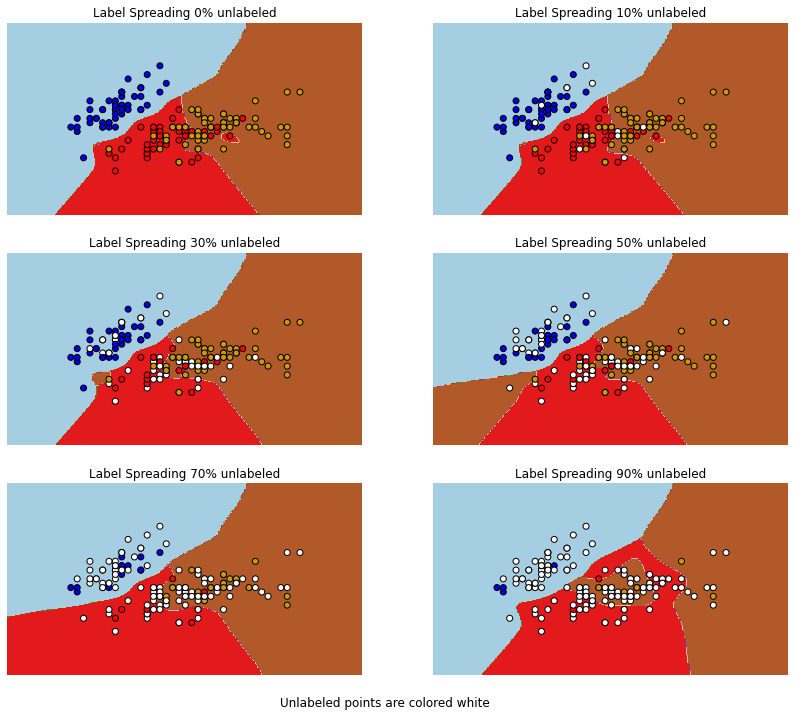

In [7]:
# step size in the mesh
h = 0.02
# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

color_map = {-1: (1, 1, 1), 0: (0, 0, 0.9), 1: (1, 0, 0), 2: (0.8, 0.6, 0)}

classifiers = (ls0,ls10, ls30, ls50, ls70, ls90)
plt.figure(figsize=(14, 12))
for i, (clf, y_train, _ , title) in enumerate(classifiers):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(3, 2, i + 1)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    plt.axis("off")

    # Plot also the training points
    colors = [color_map[y] for y in y_train]
    plt.scatter(X[:, 0], X[:, 1], c=colors, edgecolors="black")

    plt.title(title)

plt.suptitle("Unlabeled points are colored white", y=0.1)
plt.show()

### SelfTrainingClassifier / SVC

#### References
- https://scikit-learn.org/stable/auto_examples/semi_supervised/plot_semi_supervised_versus_svm_iris.html#sphx-glr-auto-examples-semi-supervised-plot-semi-supervised-versus-svm-iris-py
- https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.SelfTrainingClassifier.html#sklearn.semi_supervised.SelfTrainingClassifier

In [40]:
# fit
# the base classifier for self-training is identical to the SVC
base_classifier = SVC(kernel="rbf", gamma=0.5, probability=True)
st10 = (SelfTrainingClassifier(base_classifier).fit(X, y_10), y_10, "Self-training 10% unlabeled",)
st30 = (SelfTrainingClassifier(base_classifier).fit(X, y_30), y_30, "Self-training 30% unlabeled",)
st50 = (SelfTrainingClassifier(base_classifier).fit(X, y_50), y_50, "Self-training 50% unlabeled",)
st70 = (SelfTrainingClassifier(base_classifier).fit(X, y_70), y_70, "Self-training 70% unlabeled",)
st90 = (SelfTrainingClassifier(base_classifier).fit(X, y_90), y_90, "Self-training 90% unlabeled",)
rbf_svc = (SVC(kernel="rbf", gamma=0.5).fit(X, y), y, "SVC with rbf kernel")

#### decision boundary

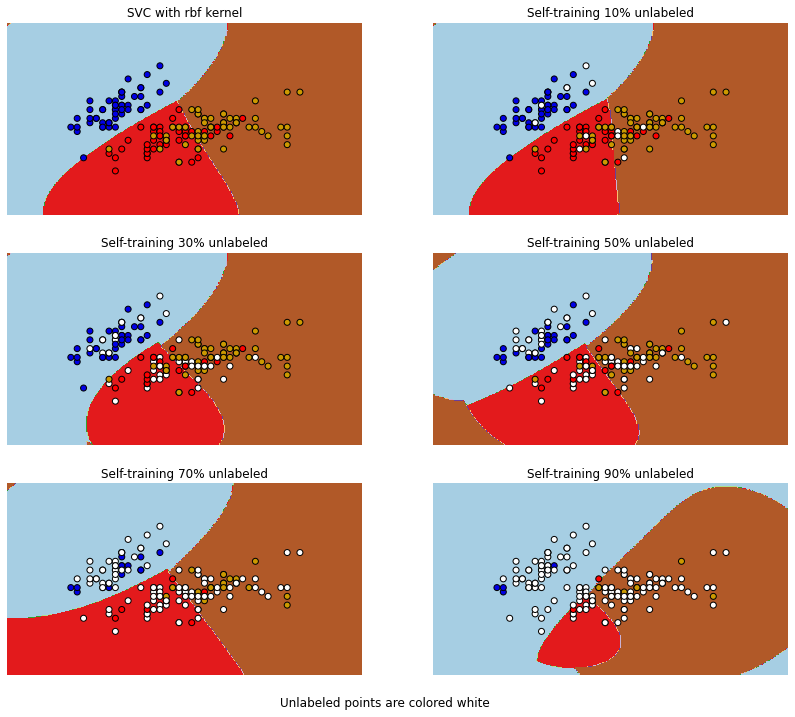

In [41]:
# step size in the mesh
h = 0.02
# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

color_map = {-1: (1, 1, 1), 0: (0, 0, 0.9), 1: (1, 0, 0), 2: (0.8, 0.6, 0)}

classifiers = (rbf_svc, st10, st30, st50, st70, st90)
plt.figure(figsize=(14, 12))
for i, (clf, y_train, title) in enumerate(classifiers):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(3, 2, i + 1)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    plt.axis("off")

    # Plot also the training points
    colors = [color_map[y] for y in y_train]
    plt.scatter(X[:, 0], X[:, 1], c=colors, edgecolors="black")

    plt.title(title)

plt.suptitle("Unlabeled points are colored white", y=0.1)
plt.show()